# Neural Machine Translation
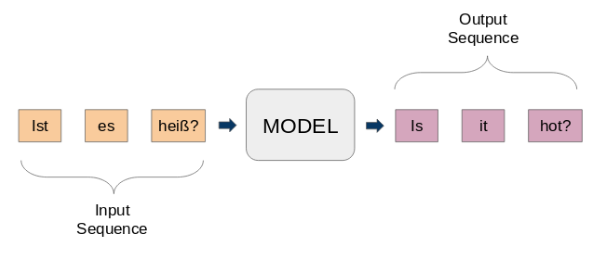

### Import Required Libraries

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt

#### Download Data

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown 1Jt5s-oexY1IfGTVrPBGok-QGTWSEsj8n

Downloading...
From: https://drive.google.com/uc?id=1Jt5s-oexY1IfGTVrPBGok-QGTWSEsj8n
To: /content/English-German.csv
100% 7.33M/7.33M [00:00<00:00, 17.1MB/s]


### Read Data

In [ ]:
df = pd.read_csv("/content/English-German.csv")

In [ ]:
df

,English Sentence,German Sentence
0,Go.,Geh.
1,Hi.,Hallo!
2,Hi.,Grüß Gott!
3,Run!,Lauf!
4,Run.,Lauf!
...,...,...
138169,Carbon monoxide poisoning can cause hallucinat...,Eine Kohlenmonoxidvergiftung kann Halluzinatio...
138170,Even intelligent people are sometimes absent-m...,Sogar intelligente Menschen sind manchmal geis...
138171,Tom's great-great-great grandmother lived in S...,Toms Altgroßmutter lebte in Schottland.
138172,Tom's great-great-great grandmother lived in S...,Toms Urururgroßmutter lebte in Schottland.


In [ ]:
len(df)

138174

In [ ]:
df = df[:50000]

### Text Pre-Processing

#### Text Cleaning

We will get rid of the punctuation marks, and then convert the text to lower case.

In [ ]:
def remove_punct_lower(text):
  cleaned = text.translate(str.maketrans('', '', string.punctuation)).lower()
  return cleaned

In [ ]:
df['English Sentence'] = df['English Sentence'].apply(remove_punct_lower)
df['German Sentence'] = df['German Sentence'].apply(remove_punct_lower)

<ipython-input-10-096acc4abe0d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['English Sentence'] = df['English Sentence'].apply(remove_punct_lower)
<ipython-input-10-096acc4abe0d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['German Sentence'] = df['German Sentence'].apply(remove_punct_lower)


In [ ]:
df.head()

,English Sentence,German Sentence
0,go,geh
1,hi,hallo
2,hi,grüß gott
3,run,lauf
4,run,lauf


#### Text to Sequence Encoding

To feed our data in a Seq2Seq model, we have to:
- convert both the input and the output sentences into integer sequences of fixed length.

In [ ]:
df['English Sentence length'] = df['English Sentence'].map(lambda i: len(i.split()))
df['German Sentence length'] = df['German Sentence'].map(lambda i: len(i.split()))

<ipython-input-12-1743de9f735a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['English Sentence length'] = df['English Sentence'].map(lambda i: len(i.split()))
<ipython-input-12-1743de9f735a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['German Sentence length'] = df['German Sentence'].map(lambda i: len(i.split()))


In [ ]:
df.head()

,English Sentence,German Sentence,English Sentence length,German Sentence length
0,go,geh,1,1
1,hi,hallo,1,1
2,hi,grüß gott,1,2
3,run,lauf,1,1
4,run,lauf,1,1


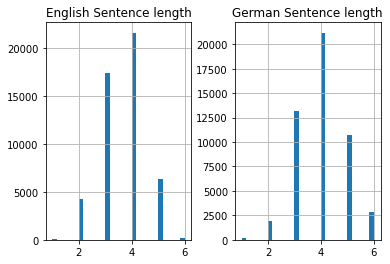

In [ ]:
df[['English Sentence length','German Sentence length']].hist(bins = 30)
plt.show()

In [ ]:
df['English Sentence length'].max()

6

In [ ]:
df['German Sentence length'].max()

6

In [ ]:
eng_length = 6
deu_length = 6

The maximum length of the German and English sentences is 6.

Vectorize the text data:
- Turn sentences into sequences of integers.
- Pad those sequences with zeros to make all the sequences of same length.

In [ ]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

Prepare English tokenizer

In [ ]:
eng_tokenizer = tokenization(df['English Sentence'])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6132


Prepare German tokenizer

In [ ]:
deu_tokenizer = tokenization(df['German Sentence'])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10037


Function to prepare the sequences:
- Convert text into vectors.
- Pad sequence.

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values , padding='post', padding is added to the end of the sequence
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state = 12)

In [ ]:
train

,English Sentence,German Sentence,English Sentence length,German Sentence length
35235,tom wants to watch,tom will zusehen,4,3
36936,are you coming tom,kommst du tom,4,3
46486,i dont feel so well,ich fühle mich nicht so gut,5,6
27160,tom has been shot,tom ist erschossen worden,4,4
19490,mail this letter,sende diesen brief,3,3
...,...,...,...,...
36482,you have the floor,sie haben das wort,4,4
40177,it was just a guess,das war nur eine schätzung,5,5
19709,please be honest,sei bitte ehrlich,3,3
38555,i dont go out much,ich gehe nicht oft aus,5,5


It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [ ]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train['German Sentence'])
trainY = encode_sequences(eng_tokenizer, eng_length, train['English Sentence'])

In [ ]:
# prepare test data
testX = encode_sequences(deu_tokenizer, deu_length, test['German Sentence'])
testY = encode_sequences(eng_tokenizer, eng_length, test['English Sentence'])

Define the Seq2Seq model architecture:
- Encoder: Embedding layer and an LSTM layer
- Decoder: LSTM layer followed by a Dense layer.

In [ ]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    '''
    in_vocab:  the size of the input vocabulary (German Vocab size)
    out_vocab: the size of the output vocabulary (English Vocab size)
    in_timesteps: the length of the input sequence (6)
    out_timesteps: the length of the output sequence (6)
    units: the number of units in the LSTM layers of the model

    '''
    # create a new sequential model
    model = Sequential()

    # convert the input sequence into a dense vector representation
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)) # input shape (batch size,6) => (batch size,6,512)

    # process the embedded input sequence and extract features that can be used to generate the output sequence
    model.add(LSTM(units)) # (output shape => (None,512))

    model.add(RepeatVector(out_timesteps)) # (output shape => (None,6,512))

    # Processes the repeated output from the previous layer and generates a sequence of output vectors
    model.add(LSTM(units, return_sequences=True)) # (output shape => (None,6,512))

    # Generate a probability distribution over the output vocabulary for each element in the output sequence
    model.add(Dense(out_vocab, activation='softmax')) # (output shape => (None,6,vocab size))

    return model

In [ ]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 6, 512)            5138944   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 6, 512)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 6, 512)            2099200   
                                                                 
 dense (Dense)               (None, 6, 6132)           3145716   
                                                                 
Total params: 12,483,060
Trainable params: 12,483,060
Non-trainable params: 0
____________________________________________

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss.

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [ ]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = 'ModelWeights.12_Mar_23'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# reshaping trainY to match the shape of the output of the last layer of the model, which has shape (batch_size, out_timesteps, out_vocab)
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
          epochs=30, batch_size=512,
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 4.2389
Epoch 1: val_loss improved from inf to 3.65691, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 27s 284ms/step - loss: 4.2389 - val_loss: 3.6569
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 3.5510
Epoch 2: val_loss improved from 3.65691 to 3.51800, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 255ms/step - loss: 3.5510 - val_loss: 3.5180
Epoch 3/30
62/63 [============================>.] - ETA: 0s - loss: 3.3106
Epoch 3: val_loss improved from 3.51800 to 3.30196, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 252ms/step - loss: 3.3100 - val_loss: 3.3020
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 3.0941
Epoch 4: val_loss improved from 3.30196 to 3.12385, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 264ms/step - loss: 3.0941 - val_loss: 3.1239
Epoch 5/30
63/63 [==============================] - ETA: 0s - loss: 2.9200
Epoch 5: val_loss improved from 3.12385 to 2.98711, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 257ms/step - loss: 2.9200 - val_loss: 2.9871
Epoch 6/30
62/63 [============================>.] - ETA: 0s - loss: 2.7519
Epoch 6: val_loss improved from 2.98711 to 2.84240, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 258ms/step - loss: 2.7517 - val_loss: 2.8424
Epoch 7/30
62/63 [============================>.] - ETA: 0s - loss: 2.5874
Epoch 7: val_loss improved from 2.84240 to 2.70897, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 264ms/step - loss: 2.5864 - val_loss: 2.7090
Epoch 8/30
62/63 [============================>.] - ETA: 0s - loss: 2.4292
Epoch 8: val_loss improved from 2.70897 to 2.58485, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 258ms/step - loss: 2.4294 - val_loss: 2.5848
Epoch 9/30
63/63 [==============================] - ETA: 0s - loss: 2.2825
Epoch 9: val_loss improved from 2.58485 to 2.49124, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 260ms/step - loss: 2.2825 - val_loss: 2.4912
Epoch 10/30
62/63 [============================>.] - ETA: 0s - loss: 2.1447
Epoch 10: val_loss improved from 2.49124 to 2.40088, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 17s 268ms/step - loss: 2.1452 - val_loss: 2.4009
Epoch 11/30
62/63 [============================>.] - ETA: 0s - loss: 2.0187
Epoch 11: val_loss improved from 2.40088 to 2.31288, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 254ms/step - loss: 2.0185 - val_loss: 2.3129
Epoch 12/30
62/63 [============================>.] - ETA: 0s - loss: 1.9000
Epoch 12: val_loss improved from 2.31288 to 2.23486, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 255ms/step - loss: 1.8993 - val_loss: 2.2349
Epoch 13/30
63/63 [==============================] - ETA: 0s - loss: 1.7865
Epoch 13: val_loss improved from 2.23486 to 2.18495, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 265ms/step - loss: 1.7865 - val_loss: 2.1850
Epoch 14/30
63/63 [==============================] - ETA: 0s - loss: 1.6770
Epoch 14: val_loss improved from 2.18495 to 2.12023, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 259ms/step - loss: 1.6770 - val_loss: 2.1202
Epoch 15/30
63/63 [==============================] - ETA: 0s - loss: 1.5757
Epoch 15: val_loss improved from 2.12023 to 2.05281, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 257ms/step - loss: 1.5757 - val_loss: 2.0528
Epoch 16/30
63/63 [==============================] - ETA: 0s - loss: 1.4761
Epoch 16: val_loss improved from 2.05281 to 1.99553, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 17s 266ms/step - loss: 1.4761 - val_loss: 1.9955
Epoch 17/30
62/63 [============================>.] - ETA: 0s - loss: 1.3832
Epoch 17: val_loss improved from 1.99553 to 1.96184, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 254ms/step - loss: 1.3831 - val_loss: 1.9618
Epoch 18/30
62/63 [============================>.] - ETA: 0s - loss: 1.2928
Epoch 18: val_loss improved from 1.96184 to 1.92462, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 256ms/step - loss: 1.2926 - val_loss: 1.9246
Epoch 19/30
62/63 [============================>.] - ETA: 0s - loss: 1.2095
Epoch 19: val_loss improved from 1.92462 to 1.86664, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 264ms/step - loss: 1.2090 - val_loss: 1.8666
Epoch 20/30
63/63 [==============================] - ETA: 0s - loss: 1.1260
Epoch 20: val_loss improved from 1.86664 to 1.84015, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 262ms/step - loss: 1.1260 - val_loss: 1.8402
Epoch 21/30
62/63 [============================>.] - ETA: 0s - loss: 1.0471
Epoch 21: val_loss improved from 1.84015 to 1.80915, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 257ms/step - loss: 1.0478 - val_loss: 1.8092
Epoch 22/30
62/63 [============================>.] - ETA: 0s - loss: 0.9737
Epoch 22: val_loss improved from 1.80915 to 1.78304, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 260ms/step - loss: 0.9741 - val_loss: 1.7830
Epoch 23/30
63/63 [==============================] - ETA: 0s - loss: 0.9039
Epoch 23: val_loss improved from 1.78304 to 1.76086, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 255ms/step - loss: 0.9039 - val_loss: 1.7609
Epoch 24/30
62/63 [============================>.] - ETA: 0s - loss: 0.8354
Epoch 24: val_loss improved from 1.76086 to 1.74329, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 260ms/step - loss: 0.8359 - val_loss: 1.7433
Epoch 25/30
62/63 [============================>.] - ETA: 0s - loss: 0.7741
Epoch 25: val_loss improved from 1.74329 to 1.72745, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 264ms/step - loss: 0.7747 - val_loss: 1.7275
Epoch 26/30
62/63 [============================>.] - ETA: 0s - loss: 0.7150
Epoch 26: val_loss improved from 1.72745 to 1.69259, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 256ms/step - loss: 0.7150 - val_loss: 1.6926
Epoch 27/30
62/63 [============================>.] - ETA: 0s - loss: 0.6586
Epoch 27: val_loss did not improve from 1.69259
63/63 [==============================] - 3s 51ms/step - loss: 0.6588 - val_loss: 1.7075
Epoch 28/30
62/63 [============================>.] - ETA: 0s - loss: 0.6071
Epoch 28: val_loss improved from 1.69259 to 1.66605, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 17s 272ms/step - loss: 0.6073 - val_loss: 1.6661
Epoch 29/30
63/63 [==============================] - ETA: 0s - loss: 0.5579
Epoch 29: val_loss did not improve from 1.66605
63/63 [==============================] - 3s 51ms/step - loss: 0.5579 - val_loss: 1.6780
Epoch 30/30
63/63 [==============================] - ETA: 0s - loss: 0.5117
Epoch 30: val_loss improved from 1.66605 to 1.65656, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 259ms/step - loss: 0.5117 - val_loss: 1.6566


Let's compare the training loss and the validation loss.

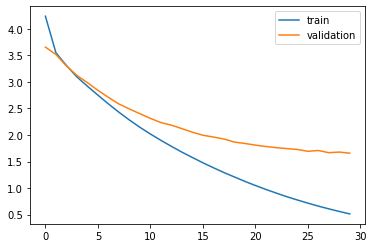

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [ ]:
!gdown 1rJEUSIIjU_nUZ5KkH3TtUIxk0XECPhRy

Downloading...
From: https://drive.google.com/uc?id=1rJEUSIIjU_nUZ5KkH3TtUIxk0XECPhRy
To: /content/ModelWeights.12_Mar_23.zip
100% 89.7M/89.7M [00:02<00:00, 42.1MB/s]


In [ ]:
!unzip /content/ModelWeights.12_Mar_23.zip

Archive:  /content/ModelWeights.12_Mar_23.zip
   creating: content/ModelWeights.12_Mar_23/
 extracting: content/ModelWeights.12_Mar_23/fingerprint.pb  
   creating: content/ModelWeights.12_Mar_23/assets/
   creating: content/ModelWeights.12_Mar_23/variables/
  inflating: content/ModelWeights.12_Mar_23/variables/variables.index  
  inflating: content/ModelWeights.12_Mar_23/variables/variables.data-00000-of-00001  
  inflating: content/ModelWeights.12_Mar_23/saved_model.pb  
  inflating: content/ModelWeights.12_Mar_23/keras_metadata.pb  


In [ ]:
model = load_model('/content/content/ModelWeights.12_Mar_23')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
preds = [np.argmax(i,axis=1) for i in preds]

313/313 [==============================] - 7s 4ms/step


In [ ]:
preds_text = eng_tokenizer.sequences_to_texts(preds)

In [ ]:
pred_df = pd.DataFrame({'actual' : test['English Sentence'], 'predicted' : preds_text})

In [ ]:
pred_df.head(15)

,actual,predicted
34622,tom is a true poet,tom is a a poet
1163,tom knows,tom knows
7637,tom phoned us,tom called us
7045,please listen,please please
43847,where have you been,where were you been
40867,please listen to us,please listen to
45653,have it your own way,do what you
42099,tom felt humiliated,tom felt flattered
17636,he wears glasses,he a glasses
42703,tom may leave early,tom can to wait


In [ ]:
pred_df.tail(15)

,actual,predicted
23752,how do we find it,how do we do it
15259,tom is far away,tom is gone
27822,tom peeked inside,tom went inside
31871,i was scared stiff,i had a stroke
22059,what is he doing,what does he do
24787,i was tired today,i was quite today
16690,a deal is a deal,smoking is dry
1980,tom paused,tom began
36656,youre always busy,youre always busy
12835,i cant breathe,i dont live


In [ ]:
from nltk.translate.bleu_score import sentence_bleu

translations = {
    'actual': [["how", "do", "we", "find", "it"]],
    'predicted': [["how", "do", "we", "do", "it"]]
}

pred_df = pd.DataFrame(translations)

pred_df['BLEU'] = pred_df.apply(lambda row: sentence_bleu(row['actual'],row['predicted']), axis=1)
pred_df

,actual,predicted,BLEU
0,"[how, do, we, find, it]","[how, do, we, do, it]",0
